# Basic Regression

In [1]:
# https://www.tensorflow.org/tutorials/keras/basic_regression

## Regression: predict fuel efficiency

In [19]:
# Use seaborn for pairplot
!pip install -q seaborn

In [20]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [21]:
print(tf.__tf.version__)

AttributeError: module 'tensorflow' has no attribute '__tf'

###  Download the Auto MPG dataset

In [22]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'C:\\Users\\HP\\.keras\\datasets\\auto-mpg.data'

### Import it using pandas

In [23]:
column_names = ['MPG','Cylinders','Displacement','Horse Power', 'Weight','Acceleration','Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path,
                          names = column_names,
                         na_values='?',
                         comment='\t',
                         sep=" ",
                         skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horse Power,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [24]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horse Power     6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [25]:
dataset = dataset.dropna()

In [26]:
origin = dataset.pop('Origin')

In [27]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horse Power,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [28]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

###  Inspect the data

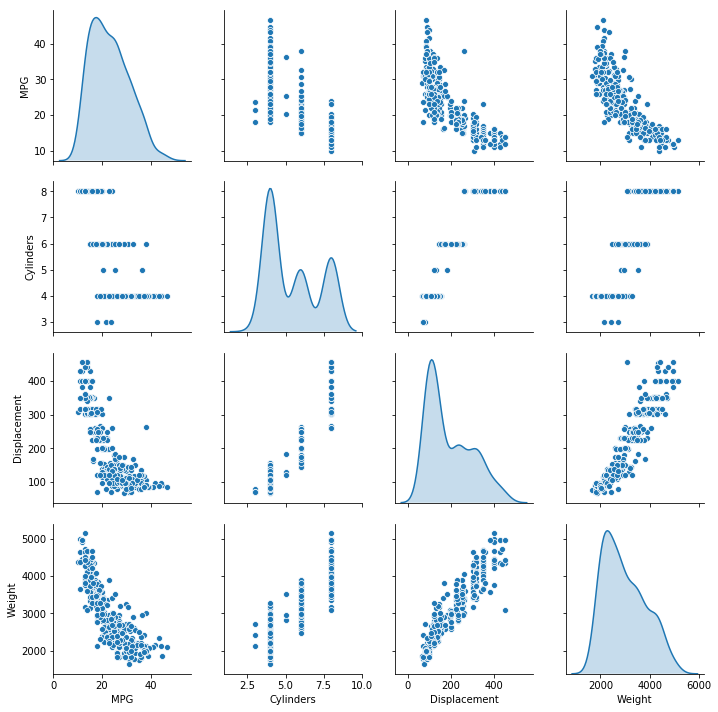

In [29]:
sns.pairplot(train_dataset[['MPG','Cylinders','Displacement', 'Weight']], diag_kind = 'kde')

In [30]:
# Also look at the overall statistics:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horse Power,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [31]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

###  Normalize the data

In [32]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

##  The Model

###  Build the Model

In [39]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [40]:
model= build_model()

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [43]:
# try model
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.1744963 ],
       [ 0.18335417],
       [ 0.70412636],
       [ 0.10759388],
       [ 0.2819068 ],
       [ 0.26813707],
       [ 0.22053924],
       [ 0.48480508],
       [ 0.22024426],
       [-0.19452411]], dtype=float32)

###  Train the Model
Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

In [46]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch %100 ==0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(normed_train_data,train_labels,
                   epochs=EPOCHS, validation_split=0.2,
                   verbose=0,
                   callbacks = [PrintDot()]
                   )


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [47]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.340364,0.985342,2.340364,10.625700,2.481874,10.625699,995
996,2.606957,1.102248,2.606957,9.238150,2.374230,9.238150,996
997,2.371225,0.996771,2.371226,9.138854,2.334213,9.138854,997
998,2.294839,0.976054,2.294839,10.504202,2.462353,10.504203,998
999,2.264239,0.996160,2.264239,9.126176,2.333747,9.126176,999


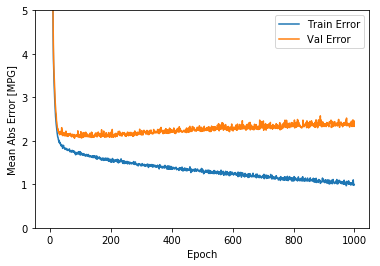

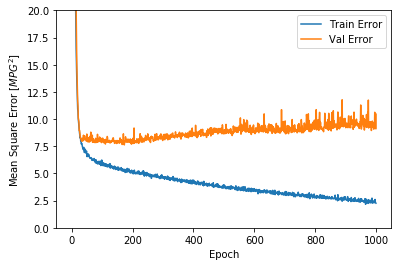

In [48]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve.


....................................................................................................
.............................

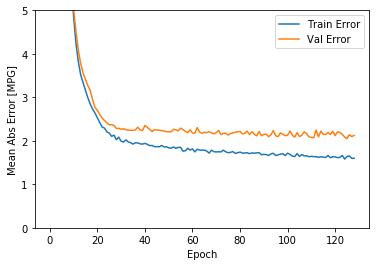

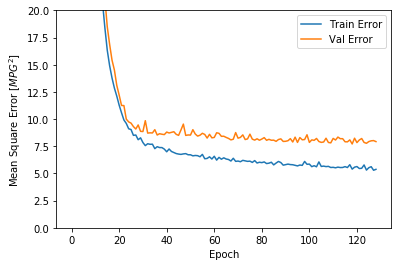

In [49]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

###  Evaluate

In [50]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.95 MPG


###  Make Predictions

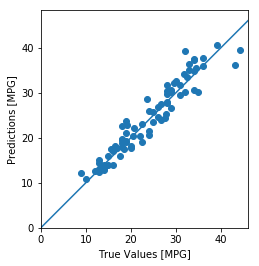

In [51]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

### Error Distrubution

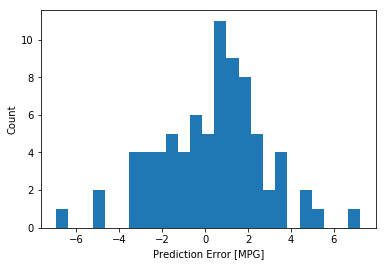

In [52]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

# Conclusion
This notebook introduced a few techniques to handle a regression problem.
- Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used
    for classification problems).
- Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
- When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
- If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
- Early stopping is a useful technique to prevent overfitting.